In [ ]:
!nvidia-smi

Sun Jul 19 23:47:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

INSTALAMOS LOS NECESARIO


In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 778kB 8.8MB/s 
     |████████████████████████████████| 3.0MB 44.0MB/s 
     |████████████████████████████████| 1.1MB 55.4MB/s 
     |████████████████████████████████| 890kB 54.7MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
transformers 3.0.2


IMPORTAMOS LAS LIBRERIAS NECESARIAS/ALGUNOS DATOS QUE USAREMOS

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # esta funcion no fue incluida
import os

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


DESCARGAMOS NUESTRAS BASE DE DATOS DE REVIEWS

In [ ]:
!gdown --id 1eXcyqhvjKZpXQXplzrcFMbv_DiVSUdQQ
#!gdown --id 1XNNpuv8CyrEsnitcA_o_ELDj1lB_ozuY

Downloading...
From: https://drive.google.com/uc?id=1eXcyqhvjKZpXQXplzrcFMbv_DiVSUdQQ
To: /content/reviewsV2.csv
7.21MB [00:00, 44.1MB/s]


EXPLORAMOS NUESTROS DATOS

In [ ]:
df = pd.read_csv("reviewsV2.csv")
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,Unnamed: 12,Unnamed: 13
0,0,gp:AOqpTOH4B-QZyWwoqUcGFpdcZtTM7IH-LLXi27wVA1y...,alexis cazares,https://lh3.googleusercontent.com/-O9lnImjLpdY...,"Con la actualización, no me deja acceder a mi ...",1,13921.0,6.0.022.02.45,2020-02-24 17:52:25,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
1,1,gp:AOqpTOGRJrkVPTyauYWt8h4hemaO6JNq2c3wvHzVtXN...,Aida Rus,https://lh3.googleusercontent.com/a-/AOh14Gjvh...,No me deja acceder con el correo institucional...,1,3429.0,6.0.022.02.40,2020-02-01 07:21:33,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
2,2,gp:AOqpTOF_sJHyGpjz3mtFe_XISIVDelffHIAamcKpTGC...,Alexis Ven,https://lh3.googleusercontent.com/-ok0eZU2YcyA...,Se me hace fastidioso usar esta app cuando hay...,1,3727.0,6.4.181.03.30,2020-05-28 09:09:01,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
3,3,gp:AOqpTOEKZZC0vvbdR96SbSIzUt-DMlOe-FCU5QJr2fu...,najwaa_ 96,https://lh3.googleusercontent.com/-J7KHIad9syg...,"La peor aplicación del mundo, y lo mejor que p...",1,3076.0,6.4.181.03.44,2020-06-03 06:26:08,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
4,4,gp:AOqpTOHHU-NyjzITN0i0dm9XDMC1DNn_uppNiQsk72t...,The Eoster,https://lh3.googleusercontent.com/a-/AOh14GhOv...,No me deja entrar desde que se actualizo... Ar...,1,3100.0,6.0.022.05.45c,2020-02-23 23:25:55,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN


In [ ]:
df.shape # LAS DIMENSIONES DE NEUSTROS DATOS
df.info() # LA INFORMACION COMO LOS CAMPOS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15985 entries, 0 to 15984
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            15985 non-null  int64  
 1   reviewId              15985 non-null  object 
 2   userName              15985 non-null  object 
 3   userImage             15985 non-null  object 
 4   content               15985 non-null  object 
 5   score                 15985 non-null  int64  
 6   thumbsUpCount         15984 non-null  float64
 7   reviewCreatedVersion  12635 non-null  object 
 8   at                    15985 non-null  object 
 9   replyContent          3640 non-null   object 
 10  repliedAt             3638 non-null   object 
 11  sortOrder             15982 non-null  object 
 12  appId                 15984 non-null  object 
 13  Unnamed: 12           24 non-null     object 
 14  Unnamed: 13           3 non-null      object 
dtypes: float64(1), int6

VEMOS NUESTROS DATOS

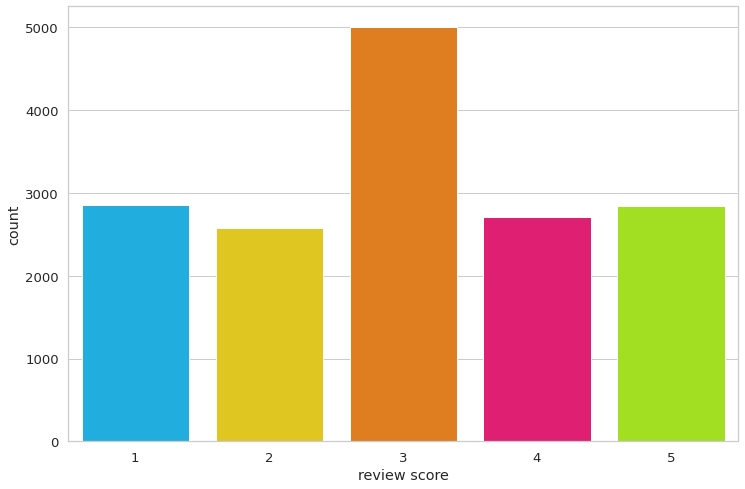

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

CONVERTIMOS NUESTROS DATOS

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)


In [ ]:
class_names = ['Negativo', 'Neutral', 'Positivo']

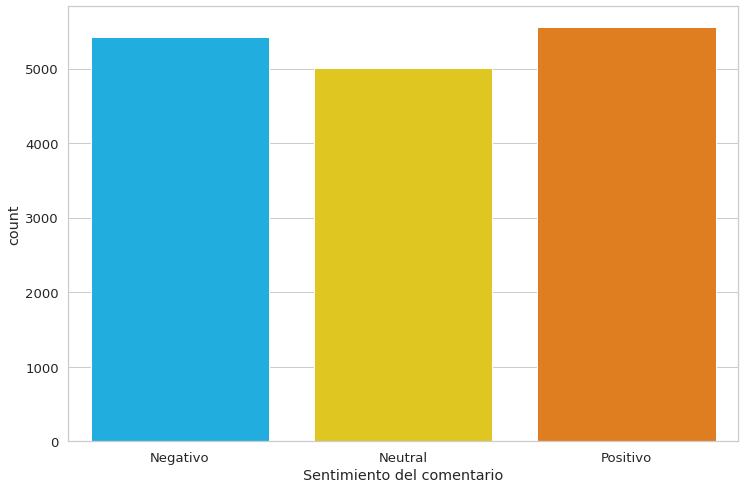

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('Sentimiento del comentario')
ax.set_xticklabels(class_names);

# PROCESAMIENTO DE NUESTROS DATOS

Cargamos nuestro modelo/ usaremos el modelo beto

In [ ]:
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'


In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'Mi nombre es juan y soy de Peru.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Mi nombre es juan y soy de Peru.
   Tokens: ['Mi', 'nombre', 'es', 'ju', '##an', 'y', 'soy', 'de', 'Per', '##u', '.']
Token IDs: [1451, 1952, 1058, 1588, 1026, 1042, 2020, 1008, 1977, 30942, 1009]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id,tokenizer.cls_token, tokenizer.cls_token_id,tokenizer.pad_token, tokenizer.pad_token_id,tokenizer.unk_token, tokenizer.unk_token_id

('[SEP]', 5, '[CLS]', 4, '[PAD]', 1, '[UNK]', 3)

In [ ]:
#necesitmoas tulizar la forma en como bert recibe nuestros reviews
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([    4,  1451,  1952,  1058,  1588,  1026,  1042,  2020,  1008,  1977,
        30942,  1009,     5,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Mi',
 'nombre',
 'es',
 'ju',
 '##an',
 'y',
 'soy',
 'de',
 'Per',
 '##u',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Buscamos la mayor logintud dentro de nuestros reviews

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

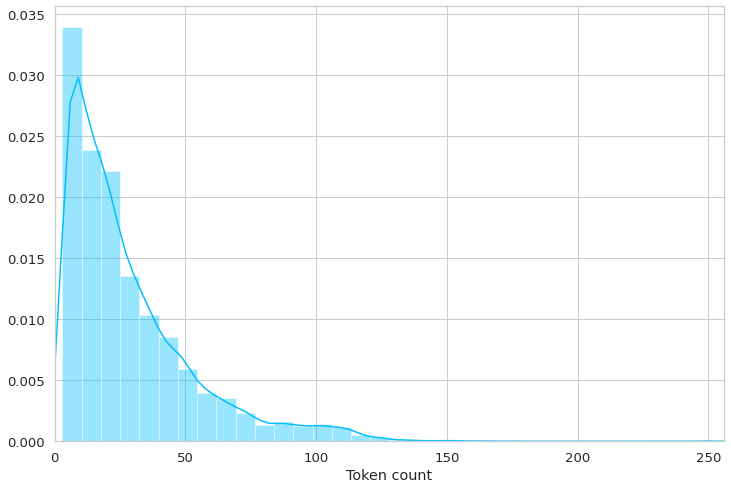

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14386, 16), (799, 16), (800, 16))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# ANALISIS DE SENTIMIENTO CON BERT

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
print(last_hidden_state.shape)
print(bert_model.config.hidden_size)
print(pooled_output.shape)

torch.Size([1, 32, 768])
768
torch.Size([1, 768])


Creamos nuestra clase que sera la encargada de el mannejo


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)


torch.Size([16, 160])
torch.Size([16, 160])


Obtenemos la probabilidades utilizando softmax en la salida

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2941, 0.5417, 0.1642],
        [0.3175, 0.4186, 0.2639],
        [0.3394, 0.4969, 0.1637],
        [0.3988, 0.4367, 0.1645],
        [0.3651, 0.4043, 0.2306],
        [0.3906, 0.3781, 0.2312],
        [0.3522, 0.3750, 0.2728],
        [0.2917, 0.5076, 0.2007],
        [0.2016, 0.6222, 0.1762],
        [0.4431, 0.4133, 0.1436],
        [0.3121, 0.3339, 0.3540],
        [0.2216, 0.6959, 0.0825],
        [0.4092, 0.3221, 0.2688],
        [0.4622, 0.3084, 0.2294],
        [0.3800, 0.4120, 0.2080],
        [0.2600, 0.5262, 0.2138]], device='cuda:0', grad_fn=<SoftmaxBackward>)

**ENTRENAMIENTO**

In [ ]:
EPOCHS = 11 # la documentacion señala que lo ideal es 3 a 4 epocas pero haremos las pruebas

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


Se recomienda los siguientes datos segun la documentacion:
1.   Batch size: 16, 32
2.   Learning rate (Adam): 5e-5, 3e-5, 2e-5
3.   Number of epochs: 2, 3, 4








In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Funcion para evaluar nuestro modelo

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), output_dir+'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/11
----------
Train loss 0.802019011411402 accuracy 0.6445850132072849
Val   loss 0.7530330467224121 accuracy 0.6695869837296621

Epoch 2/11
----------
Train loss 0.542651154200236 accuracy 0.7897261226192132
Val   loss 0.7377863144874572 accuracy 0.7409261576971214

Epoch 3/11
----------
Train loss 0.3476926612522867 accuracy 0.8778673710551925
Val   loss 0.8804289108514786 accuracy 0.7571964956195244

Epoch 4/11
----------
Train loss 0.24517897091805935 accuracy 0.9233977478103712
Val   loss 1.047400754094124 accuracy 0.7772215269086358

Epoch 5/11
----------
Train loss 0.19659363114171557 accuracy 0.9432781871263729
Val   loss 1.1504965579509736 accuracy 0.7897371714643304

Epoch 6/11
----------
Train loss 0.15842842075973748 accuracy 0.955720839705269
Val   loss 1.114929234981537 accuracy 0.7934918648310388

Epoch 7/11
----------
Train loss 0.1252917564701703 accuracy 0.9653830112609482
Val   loss 1.2261902955174446 accuracy 0.8060075093867335

Epoch 8/11
----------
Train l

Mostramos el resultados de nuestro entrenamiento

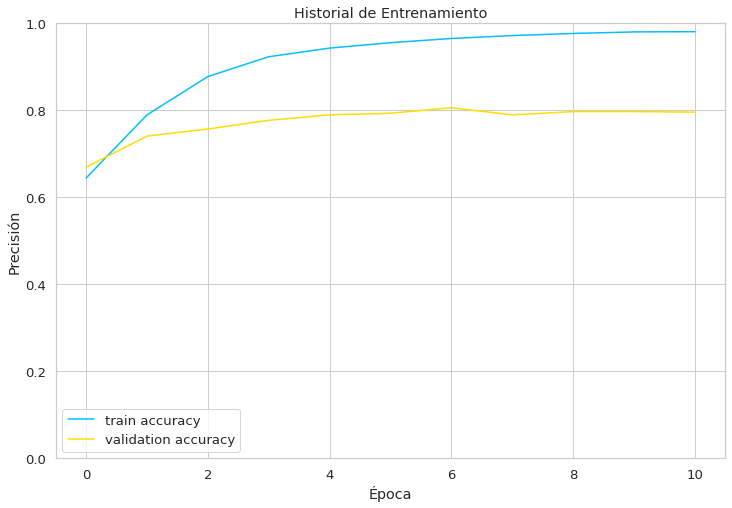

In [ ]:
plt.plot(history['train_acc'], label='Precisición de entrenamiento')
plt.plot(history['val_acc'], label='Precesición de validación')

plt.title('Historial de Entrenamiento')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.ylim([0, 1]);

Evaluamos nuestro modelo entrenado

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8075

Creamos una funcion que nos ayude para predecir nuestro modelo

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
print(y_test)
print(y_pred_probs)
print(classification_report(y_test, y_pred, target_names=class_names))

tensor([2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1,
        2, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 2, 1, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1,
        1, 2, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 1, 0,
        2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 2,
        2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2,
        0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2,
        0, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 1, 0, 2, 1, 2, 1,
        2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1,
        2, 0, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 2, 0, 1,
        0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1,
        0, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0,

Creamos una funcion para mostrar la matriz de confusion

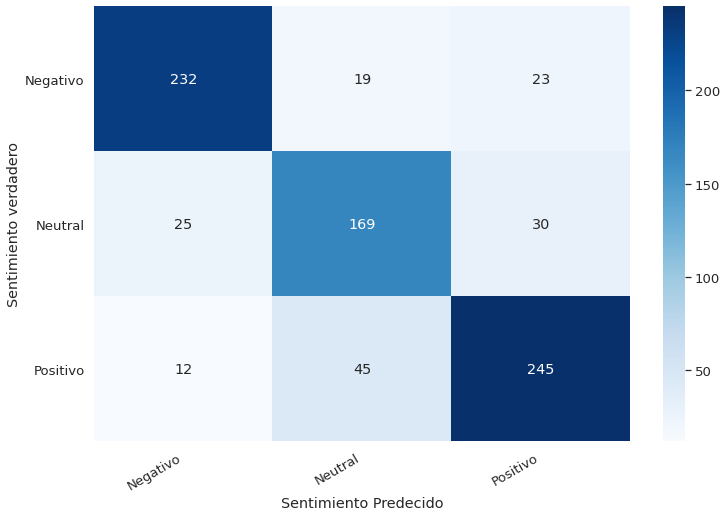

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Sentimiento verdadero')
  plt.xlabel('Sentimiento Predecido');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Cuando comenze con brainly fueron hace 2 años y me funcionaba bien las
respuestas coherentes y precisas pero cuando lo volvi a usarlo yo
quería preguntar mi duda y cuando me dieron la respuesta era inútil no
tenía ningún sentido "solo contestan para ganar puntos y suban de
rango" revise el perfil del usuario que me contesto mi duda y me di
con la sorpresa de que todas sus respuestas eran iguales y me enoje y
quiero que le quiten la cuenta a Pandaarmy21 y a otros usuarios que
hacen lo mismo.

True sentiment: negative


haremos una funcion para facilitar


In [ ]:
review_text = "deben mejorar no me permite guardar"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: deben mejorar no me permite guardar
Sentiment  : negative


Guardamos nuestro modelo

In [ ]:
from google.colab import drive


Verificamos si nuestro modelo se guardo

In [ ]:
#%cd /root/model_save/drive/
%ls


best_model_state.bin


In [ ]:
#Guardamos el Tokenize
tokenizer.save_pretrained(output_dir)


Saving directory (./model_save/) should be a directory


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#!cp -r /root/model_save/best_model_state.bin "./drive/My drive/Colab Notebooks"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp -r /root/model_save/best_model_state.bin "/content/gdrive/My Drive/Colab Notebooks"

CARGAMOS NUESTRO MODELO ENTRENADO

In [ ]:
!gdown --id 1nEP1pkj3kMLHg-OwIluSHfgsDEXkqmdO


Downloading...
From: https://drive.google.com/uc?id=1nEP1pkj3kMLHg-OwIluSHfgsDEXkqmdO
To: /root/model_save/drive/best_model_state.bin
439MB [00:02, 193MB/s]


In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)


In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
print(y_test)
print(y_pred_probs)

print(classification_report(y_test, y_pred, target_names=class_names))

tensor([0, 0, 2, 0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 0, 0, 1,
        0, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 2, 1,
        2, 1, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 0, 1, 0, 2, 1, 0, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0,
        2, 0, 1, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0])
tensor([[9.9958e-01, 1.9918e-04, 2.2337e-04],
        [9.9229e-01, 4.8571e-03, 2.8523e-03],
        [1.3134e-03, 1.0103e-03, 9.9768e-01],
        [9.6280e-01, 1.1847e-02, 2.5357e-02],
        [4.6364e-04, 9.9883e-01, 7.0224e-04],
        [4.0012e-04, 9.9862e-01, 9.7823e-04],
        [4.1607e-04, 9.9929e-01, 2.9123e-04],
        [7.0574e-04, 9.9808e-01, 1.2142e-03],
        [7.8669e-04, 1.5907e-03, 9.9762e-01],
        [9.9844e-01, 6.0735e-04, 9.5532e-04],
        [6.5907e-03, 5.2910e-01, 4.6430e-01],
        [9.9944e-01, 2.6159e-04, 2.9825e-04],
        [9.9762e-01, 1.9149e-03, 4.6485e-04],
 